<a href="https://colab.research.google.com/github/peisuke/homography-estimation/blob/main/homography_ex2_SuperPoint_RANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

Cloning into 'SuperPointPretrainedNetwork'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.


In [2]:
!pip install -U opencv-python

     |████████████████████████████████| 60.5 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import cv2
import numpy as np
import glob
from PIL import Image

In [4]:
import sys
sys.path.append('SuperPointPretrainedNetwork')

In [5]:
from demo_superpoint import SuperPointFrontend

In [6]:
!wget https://raw.githubusercontent.com/peisuke/homography-estimation/main/pair_images.zip

--2022-04-22 02:18:52--  https://raw.githubusercontent.com/peisuke/homography-estimation/main/pair_images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1508977 (1.4M) [application/zip]
Saving to: ‘pair_images.zip’

pair_images.zip     100%[===================>]   1.44M  --.-KB/s    in 0.07s   

2022-04-22 02:18:52 (21.8 MB/s) - ‘pair_images.zip’ saved [1508977/1508977]



In [7]:
!cp /content/drive/MyDrive/colab_data/pair_images.zip .
!unzip -q pair_images.zip

In [8]:
nms_dist = 4
conf_thresh = 0.015
nn_thresh = 0.7
cuda = False
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'
fe = SuperPointFrontend(weights_path=weights_path,
                          nms_dist=nms_dist,
                          conf_thresh=conf_thresh,
                          nn_thresh=nn_thresh,
                          cuda=cuda)

In [9]:
def getPairs(img1, img2, fe):
    # find the keypoints and descriptors with SIFT
    if len(img1.shape) > 2:
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    if len(img2.shape) > 2:
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    kp1, des1, _ = fe.run(img1.astype('float32')/255.0)
    kp2, des2, _ = fe.run(img2.astype('float32')/255.0)

    kp1 = [cv2.KeyPoint(k[0], k[1], k[2]) for k in kp1.transpose(1,0)]
    kp2 = [cv2.KeyPoint(k[0], k[1], k[2]) for k in kp2.transpose(1,0)]

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1.transpose(1,0), des2.transpose(1,0), k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    return kp1, kp2, good

In [10]:
def find_homography(kp1, kp2, good):
    if len(good) < 4:
        return []
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    good2 = [g for g, m in zip(good, matchesMask) if m > 0]
    return good2

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


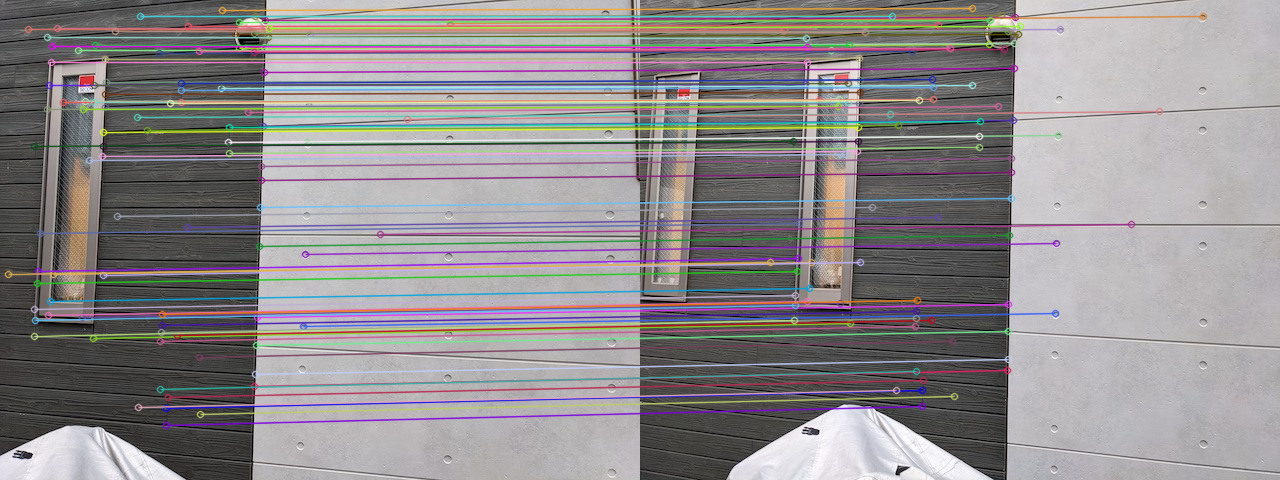

In [11]:
files = sorted(glob.glob('pair_images/pair_01/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])
kp1, kp2, good = getPairs(img1, img2, fe)
good2 = find_homography(kp1, kp2, good)
pairImg = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(pairImg, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


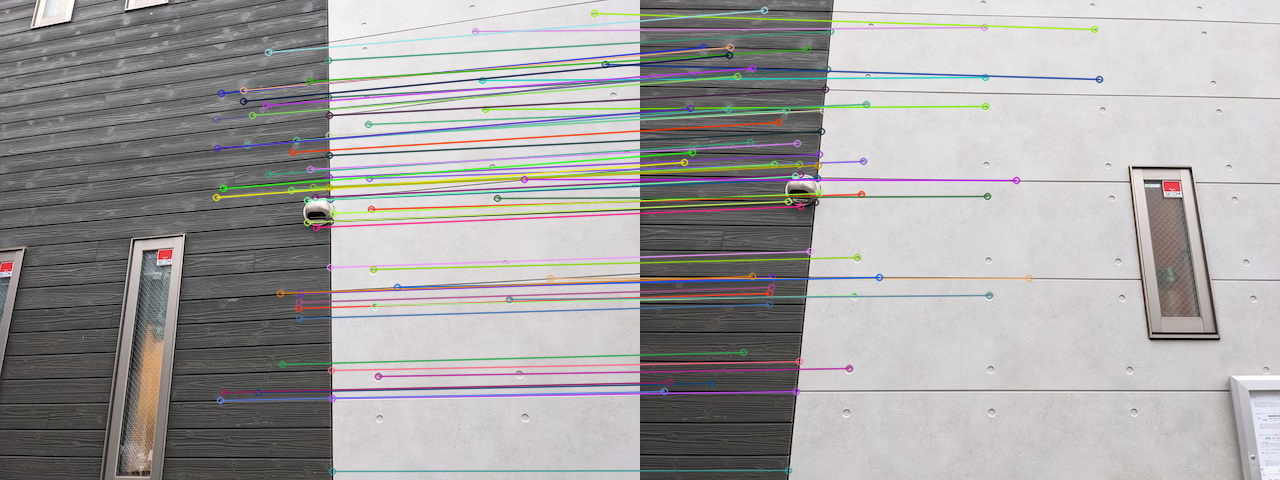

In [12]:
files = sorted(glob.glob('pair_images/pair_02/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])
kp1, kp2, good = getPairs(img1, img2, fe)
good2 = find_homography(kp1, kp2, good)
pairImg = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(pairImg, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


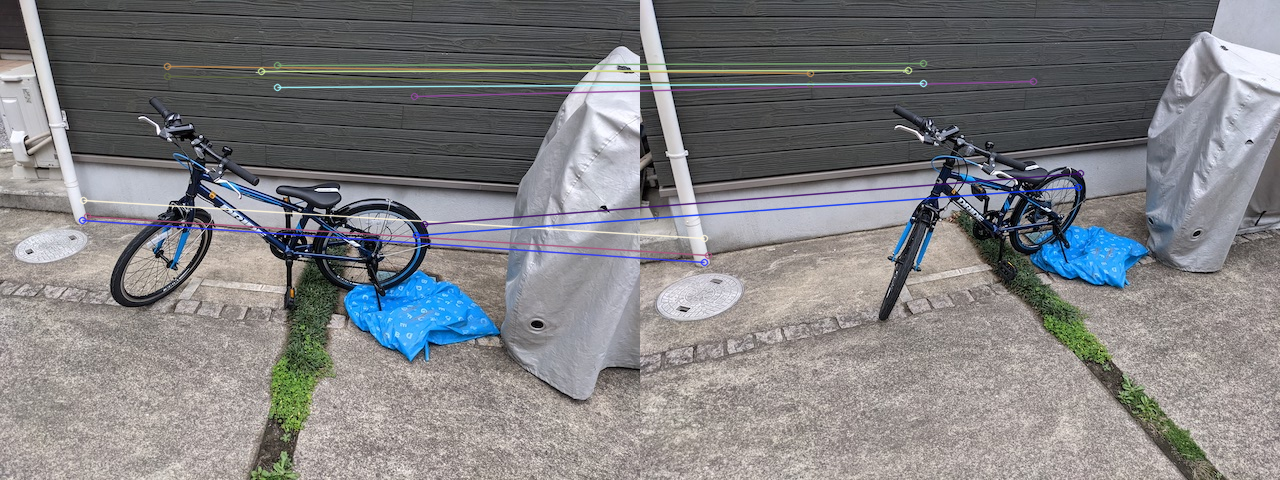

In [13]:
files = sorted(glob.glob('pair_images/pair_03/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])
kp1, kp2, good = getPairs(img1, img2, fe)
good2 = find_homography(kp1, kp2, good)
pairImg = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(pairImg, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


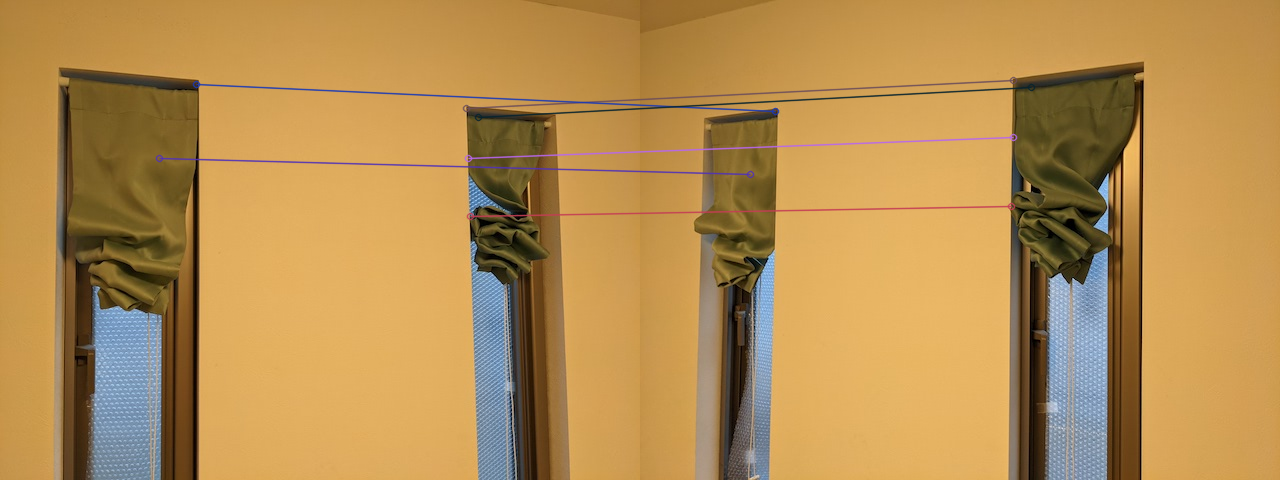

In [14]:
files = sorted(glob.glob('pair_images/pair_04/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])
kp1, kp2, good = getPairs(img1, img2, fe)
good2 = find_homography(kp1, kp2, good)
pairImg = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(pairImg, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


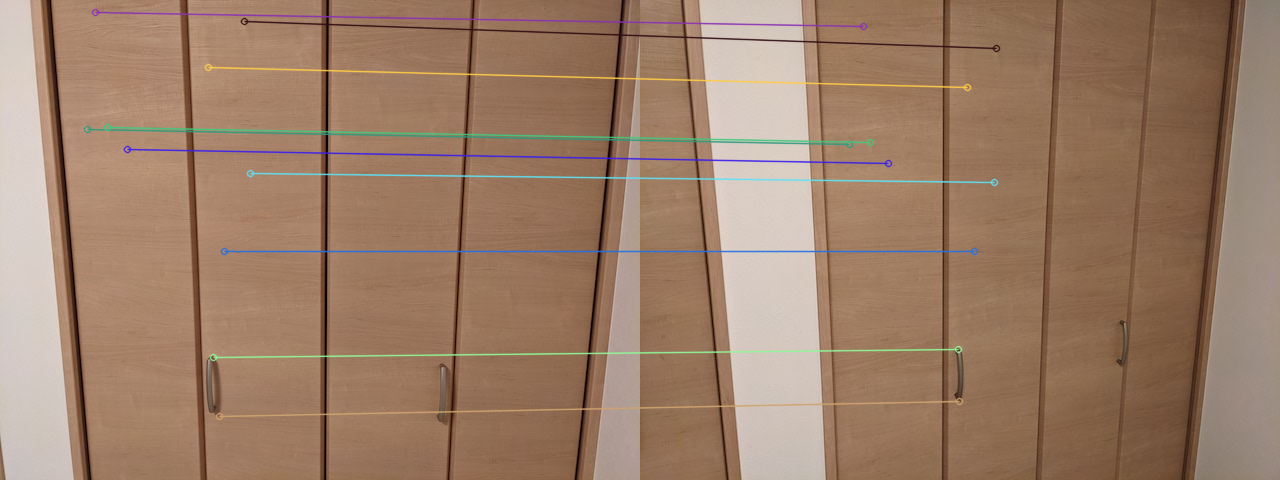

In [15]:
files = sorted(glob.glob('pair_images/pair_05/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])
kp1, kp2, good = getPairs(img1, img2, fe)
good2 = find_homography(kp1, kp2, good)
pairImg = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(pairImg, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


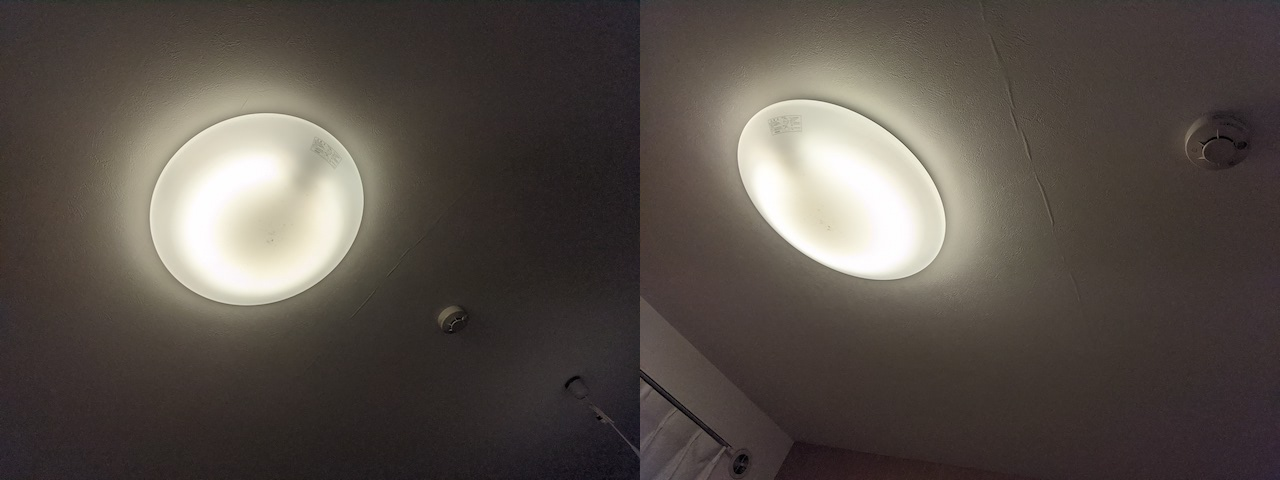

In [16]:
files = sorted(glob.glob('pair_images/pair_06/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])
kp1, kp2, good = getPairs(img1, img2, fe)
good2 = find_homography(kp1, kp2, good)
pairImg = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(pairImg, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


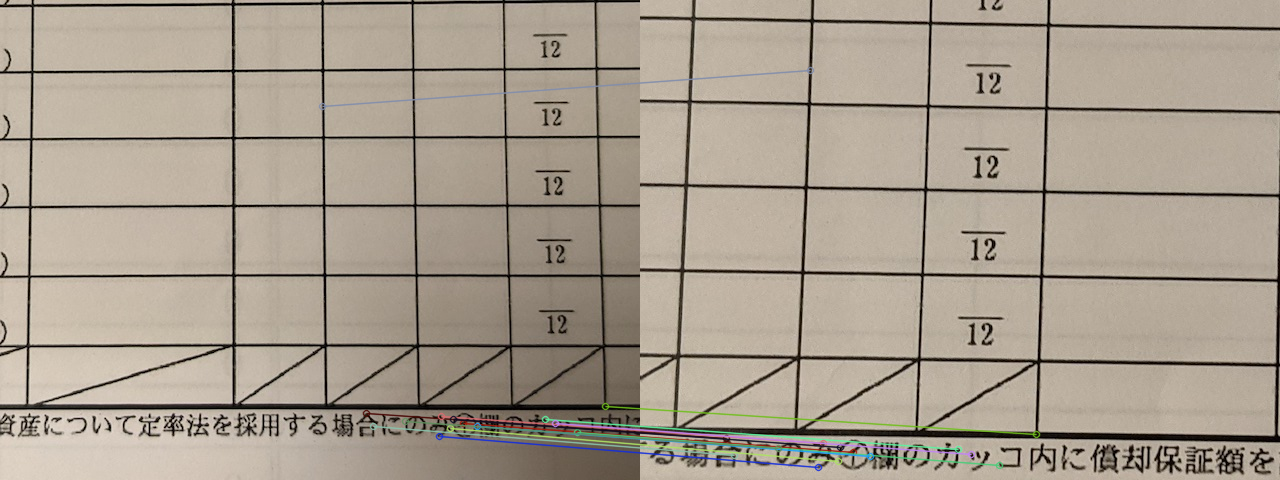

In [17]:
files = sorted(glob.glob('pair_images/pair_07/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])
kp1, kp2, good = getPairs(img1, img2, fe)
good2 = find_homography(kp1, kp2, good)
pairImg = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(pairImg, cv2.COLOR_BGR2RGB))